In [1]:
# dependencies import
from common_dependencies import *
from train_dependencies import *

In [2]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/Original data/Run1/run1_WM32_data.csv',
        'data/Original data/Run1/run1_WM32_defects.csv',
        'data/Original data/Run1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/Original data/Run2/run2_WM32_data.csv',
        'data/Original data/Run2/run2_WM32_defects.csv',
        'data/Original data/Run2/run2_WM32_pipe.csv')
}

CROP_SIZE = 16
CROP_STEP = 2

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)

# чтение данных
test_1 = pidf.PipeDataCsvWorker(*PATH_TO_DATA['run_1'])

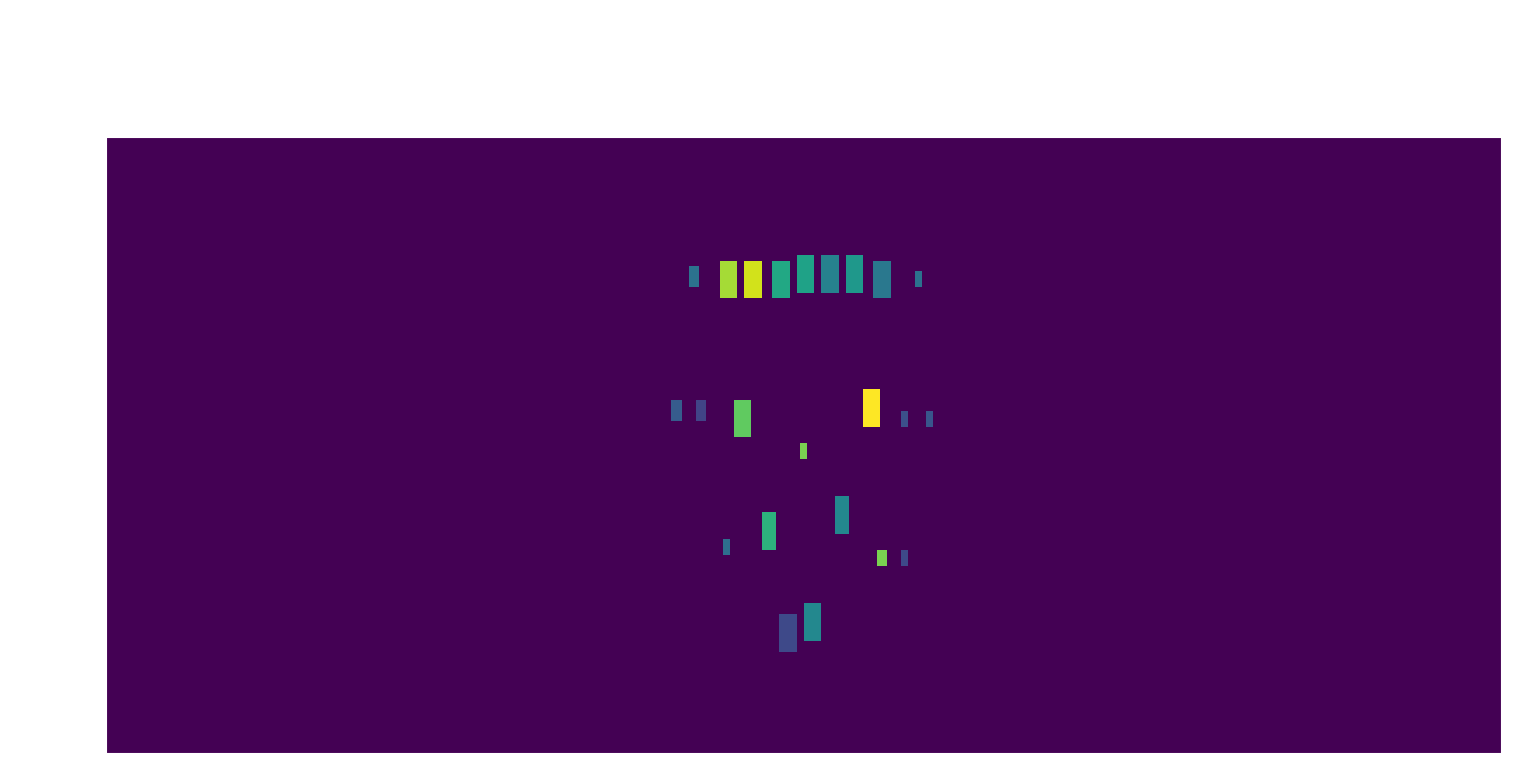

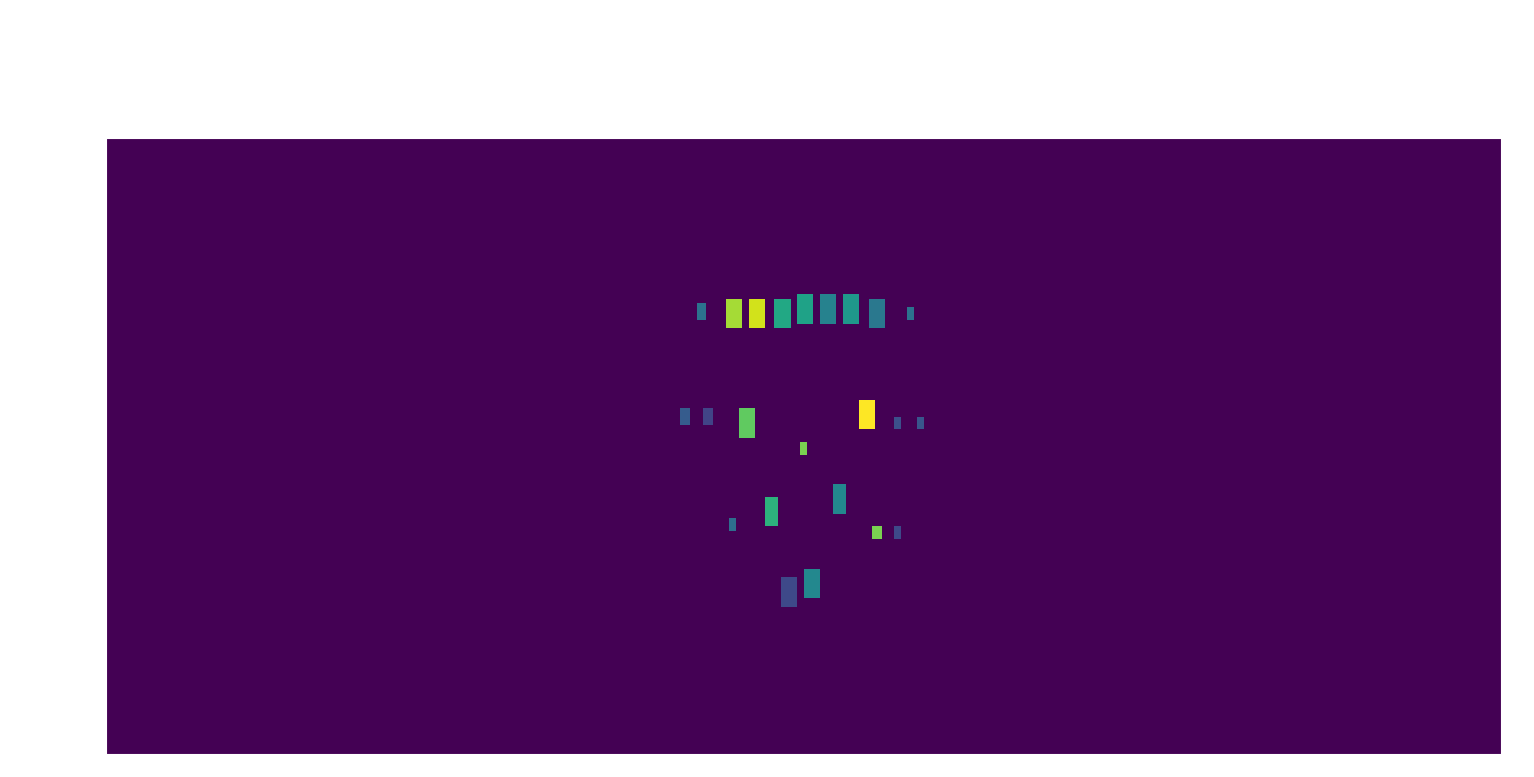

In [3]:
# Вывод считанных данных и их расширение для обучения
test_1.roll_dfs_along_axis(200, axis=1)
test_1.draw_defects_map(title='Считанная развернутая карта дефектов')
test_1.extend_dfs_for_prediction(crop_size=CROP_SIZE, crop_step=CROP_STEP)
test_1.draw_defects_map(title=f'Расширенная развернутая карта дефектов для cr.size: {CROP_SIZE} и cr.step: {CROP_STEP}')

In [4]:
# Забрать данные из класса
x_data = test_1.get_data_df()
y_data = test_1.get_defects_df()
test_1 = None

In [5]:
# преобразовать данные к виду (измерение, размер х, размер у, каналы)
# для x_data_time каналы = 32
# для x_data_amp каналы = 32
# для y_data каналы = 1
(x_data_time,
x_data_amp) = dp.reshape_X_df_to_image_like_numpy(x_data, CROP_SIZE, CROP_STEP)
y_data = dp.reshape_Y_df_to_image_like_numpy(y_data, CROP_SIZE, CROP_STEP)

||||||||||||||||||
X df reshaping to 4D
Original df size:  (146, 430)
Crop windows height/width:  16
Crop windows step across rows and cols:  2
New X_time shape:  (13728, 16, 16, 32)
New X_amp shape:  (13728, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (146, 430)
Crop windows height/width:  16
Crop windows step across rows and cols:  2
New numpy shape:  (13728, 16, 16, 1)
||||||||||||||||||



In [6]:
# нормализовать входные данные
x_data_time = dp.standartize_data(x_data_time)
x_data_amp = dp.standartize_data(x_data_amp)

||||||||||||||||||
Data standartizing
arr_max before normalization: 44.5
arr_min before normalization: 0.0
arr_max after normalization: 1.0
arr_min after normalization: 0.0
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before normalization: 62.992
arr_min before normalization: -61.968
arr_max after normalization: 1.0
arr_min after normalization: -0.983743967487935
||||||||||||||||||



In [7]:
# Поделить кропы на дефектные и нет
(x_time_def, x_time_non_def), \
(x_amp_def, x_amp_non_def), \
(y_mask_def, y_mask_non_def) = dp.split_def_and_non_def_data(x_data_time, 
                                                            x_data_amp, 
                                                            y_data, CROP_SIZE)
x_data_time = x_data_amp = y_data = None

||||||||||||||||||
Defect and non defect data splitting
Orig X_time shape:  (13728, 16, 16, 32)
Orig X_amp shape:  (13728, 16, 16, 32)
Orig Y_mask shape:  (13728, 16, 16, 1)
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 16
и общим кличеством: 13728
дефекты присутствуеют на 1332 картах
||||||||||||||||||

X_time_def shape:  (1332, 16, 16, 32)
X_time_non_def shape:  (12396, 16, 16, 32)

X_amp_def shape:  (1332, 16, 16, 32)
X_amp_non_def shape:  (12396, 16, 16, 32)

Y_mask_def shape:  (1332, 16, 16, 1)
Y_mask_non_def shape:  (12396, 16, 16, 1)

||||||||||||||||||



In [8]:
shuffled_indices = np.random.permutation(x_amp_non_def.shape[0])[:x_time_def.shape[0]]

x_time_non_def = x_time_non_def[shuffled_indices]
x_amp_non_def = x_amp_non_def[shuffled_indices]
y_mask_non_def = y_mask_non_def[shuffled_indices]

print(f'{x_time_def.shape=}')
print(f'{x_amp_def.shape=}')
print(f'{y_mask_def.shape=}\n')

print(f'{x_time_non_def.shape=}')
print(f'{x_amp_non_def.shape=}')
print(f'{y_mask_non_def.shape=}')

x_time_def.shape=(1332, 16, 16, 32)
x_amp_def.shape=(1332, 16, 16, 32)
y_mask_def.shape=(1332, 16, 16, 1)

x_time_non_def.shape=(1332, 16, 16, 32)
x_amp_non_def.shape=(1332, 16, 16, 32)
y_mask_non_def.shape=(1332, 16, 16, 1)


In [9]:
# Аугментировать данные
x_time_def = dp.augment_data(x_time_def) 
x_time_non_def = dp.augment_data(x_time_non_def) 

x_amp_def = dp.augment_data(x_amp_def) 
x_amp_non_def = dp.augment_data(x_amp_non_def) 

y_mask_def = dp.augment_data(y_mask_def) 
y_mask_non_def = dp.augment_data(y_mask_non_def) 

||||||||||||||||||
Data augmentation
Orig arr shape:  (1332, 16, 16, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (5328, 16, 16, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (10656, 16, 16, 32)
||||||||||||
After vertical full mirroring
arr shape:  (21312, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Data augmentation
Orig arr shape:  (1332, 16, 16, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (5328, 16, 16, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (10656, 16, 16, 32)
||||||||||||
After vertical full mirroring
arr shape:  (21312, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Data augmentation
Orig arr shape:  (1332, 16, 16, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (5328, 16, 16, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (10656, 16, 16, 32)
||||||||||||
After vertical full mirroring
arr shape:  (21312, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Data augment

In [10]:
# создание выходных данных бинарного вида (одномерный массив типа bool)
y_binary_def = dp.create_binary_arr_from_mask_arr(y_mask_def)
y_binary_non_def = dp.create_binary_arr_from_mask_arr(y_mask_non_def)
y_mask_def = y_mask_non_def = None

||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (21312, 16, 16, 1)
Y binary arr shape:  (21312,)
||||||||||||||||||

||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (21312, 16, 16, 1)
Y binary arr shape:  (21312,)
||||||||||||||||||



In [11]:
# деление на тренировочную и валидационную выборки

val_data_percent = 0.2

X_time_train, X_time_val = dp.split_data_to_train_val_datasets([x_time_def,
                                                                x_time_non_def],
                                                                val_data_percent)
x_time_def = x_time_non_def = None

X_amp_train, X_amp_val = dp.split_data_to_train_val_datasets([x_amp_def,
                                                              x_amp_non_def],
                                                              val_data_percent)
x_amp_def = x_amp_non_def = None

Y_binary_train, Y_binary_val = dp.split_data_to_train_val_datasets([y_binary_def,
                                                                y_binary_non_def],
                                                                val_data_percent)
y_binary_def = y_binary_non_def = None

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (21312, 16, 16, 32)
Orig item shape:  (21312, 16, 16, 32)

Result arr_train shape:  (34100, 16, 16, 32)
Result arr_val shape:  (8524, 16, 16, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (21312, 16, 16, 32)
Orig item shape:  (21312, 16, 16, 32)

Result arr_train shape:  (34100, 16, 16, 32)
Result arr_val shape:  (8524, 16, 16, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (21312,)
Orig item shape:  (21312,)

Result arr_train shape:  (34100,)
Result arr_val shape:  (8524,)

||||||||||||||||||



In [12]:
# перемешивание данных
train_shuffled_indices = np.random.permutation(X_time_train.shape[0])
val_shuffled_indices = np.random.permutation(X_time_val.shape[0])

X_time_train = X_time_train[train_shuffled_indices]
X_amp_train = X_amp_train[train_shuffled_indices]
Y_binary_train = Y_binary_train[train_shuffled_indices]

X_time_val = X_time_val[val_shuffled_indices]
X_amp_val = X_amp_val[val_shuffled_indices]
Y_binary_val = Y_binary_val[val_shuffled_indices]

In [13]:
print(f'{X_time_train.shape=}')
print(f'{X_amp_train.shape=}')
print(f'{Y_binary_train.shape=}\n')

print(f'{X_time_val.shape=}')
print(f'{X_amp_val.shape=}')
print(f'{Y_binary_val.shape=}')

X_time_train.shape=(34100, 16, 16, 32)
X_amp_train.shape=(34100, 16, 16, 32)
Y_binary_train.shape=(34100,)

X_time_val.shape=(8524, 16, 16, 32)
X_amp_val.shape=(8524, 16, 16, 32)
Y_binary_val.shape=(8524,)


In [14]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.000004 #0.04 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
#ES_patience = 15 # кол-во эпох без улучшений
#ES_min_delta = 0.0005 # минимальное улучшение параметра за cur_patience
#ES_monitor_parametr =  'loss' # отслеживаемый параметр 
#ES_save_best_weights = False # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
#RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
#RLPOP_factor = 0.4 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
#RLPOP_patience = 10 # кол-во эпох без улучшений
#RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
#RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
#RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
#RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
#RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 12 # размер bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 10 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [15]:
# создание архитектуры модели
CONV_DROP_PERCENT = 0.10
DENSE_DROP_PERCENT = 0.10
# 1 подсеть //////////////////////////////////////////////////
input_time = Input((16,16,32), name = 'input_time')

conv_1_1 = Conv2D(512, (4,4), activation='relu', name='conv_1_1')(input_time)
pool_1_1 = MaxPooling2D((2,2), strides=2, name='pool_1_1')(conv_1_1)

conv_1_2 = Conv2D(1024, (5,5), activation='relu', name='conv_1_2')(pool_1_1)
drop_1_1 = Dropout(CONV_DROP_PERCENT, name='drop_1_1')(conv_1_2)
pool_1_2 = MaxPooling2D((2,2), strides=2, name='pool_1_2')(drop_1_1)

# 2 подсеть //////////////////////////////////////////////////
input_amp = Input((16,16,32), name = 'input_amp')

conv_2_1 = Conv2D(512, (4,4), activation='linear', name='conv_2_1')(input_amp)
pool_2_1 = MaxPooling2D((2,2), strides=2, name='pool_2_1')(conv_2_1)

conv_2_2 = Conv2D(1024, (5,5), activation='linear', name='conv_2_2')(pool_2_1)
drop_2_1 = Dropout(CONV_DROP_PERCENT, name='drop_2_1')(conv_2_2)
pool_2_2 = MaxPooling2D((2,2), strides=2, name='pool_2_2')(drop_2_1)

# выходная подсеть //////////////////////////////////////////////////

conc_3_1 = concatenate([pool_1_2,pool_2_2], axis=3, name='conc_3_1')
flat_3_1 = Flatten(name='flat')(conc_3_1)

d_3_1 = Dense(4096, activation='linear', name='d_3_1')(flat_3_1)
drop_3_1 = Dropout(DENSE_DROP_PERCENT, name='drop_3_1')(d_3_1)
d_3_2 = Dense(2048, activation='linear', name='d_3_2')(drop_3_1)
drop_3_2 = Dropout(DENSE_DROP_PERCENT, name='drop_3_2')(d_3_2)
d_3_3 = Dense(512, activation='linear', name='d_3_3')(drop_3_2)
d_3_4 = Dense(128, activation='linear', name='d_3_4')(d_3_3)
d_3_5 = Dense(32, activation='linear', name='d_3_5')(d_3_4)
d_3_6 = Dense(8, activation='linear', name='d_3_6')(d_3_5)

output_3_1 = Dense(1, activation='sigmoid', name='output_3_1')(d_3_6)

model = keras.Model([input_time, input_amp], output_3_1, name='model')

model.compile(optimizer=CMP_solver, loss=CMP_loss_func)

print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_time (InputLayer)     [(None, 16, 16, 32)]         0         []                            
                                                                                                  
 input_amp (InputLayer)      [(None, 16, 16, 32)]         0         []                            
                                                                                                  
 conv_1_1 (Conv2D)           (None, 13, 13, 512)          262656    ['input_time[0][0]']          
                                                                                                  
 conv_2_1 (Conv2D)           (None, 13, 13, 512)          262656    ['input_amp[0][0]']           
                                                                                            

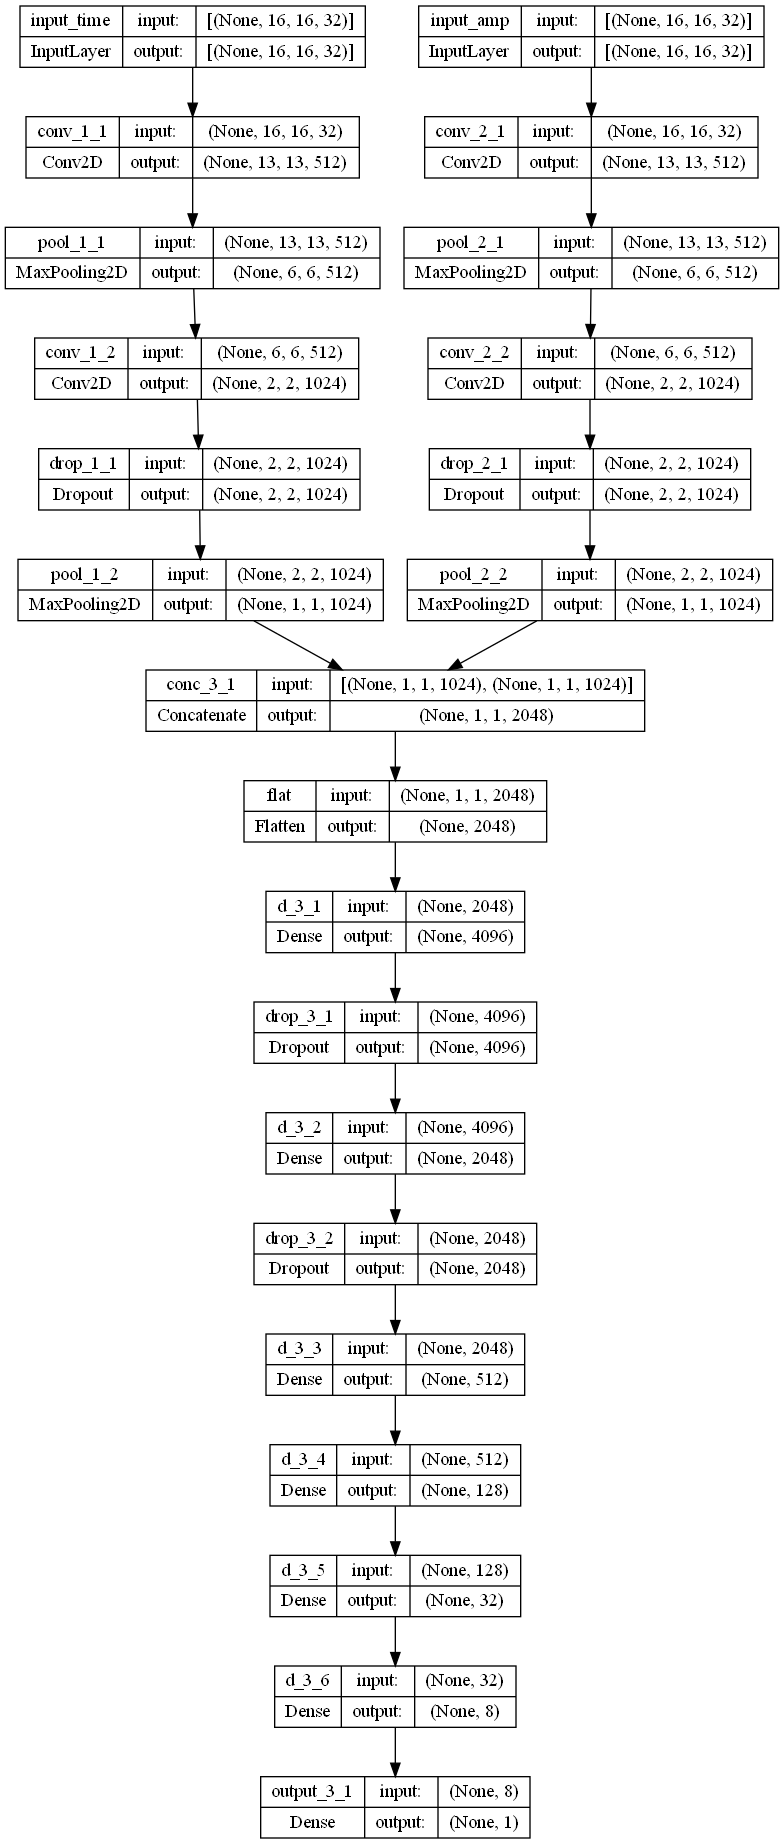

In [16]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [18]:
history = model.fit([X_time_train, X_amp_train],
                    Y_binary_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_data = ([X_time_val, X_amp_val], Y_binary_val), 
                    callbacks = FIT_callback_list)


2842/2842 [==============================] - 1106s 389ms/step - loss: 0.0080 - val_loss: 0.0106


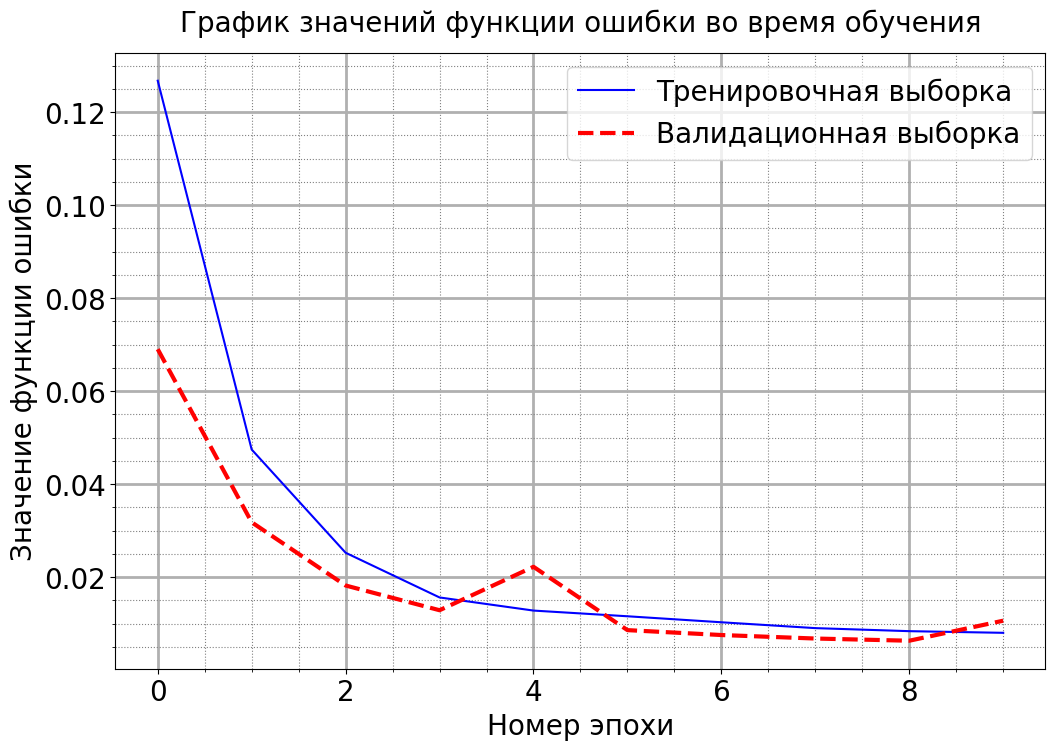

In [19]:
fig, ax = plt.subplots()

fig.set_figwidth(12)
fig.set_figheight(8)

plt.plot(history.history['loss'], 
         label='Тренировочная выборка',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', 
         label='Валидационная выборка',  linewidth=3, color='red')

ax.set_xlabel('Номер эпохи', fontsize=20)
ax.set_ylabel('Значение функции ошибки', fontsize=20)
ax.set_title(f"График значений функции ошибки во время обучения", fontsize=20, pad=15)

ax.patch.set_alpha(0)

#  Устанавливаем форматирование делений:
ax.tick_params(axis='both', which='both', labelsize = 20)

# Вывод и настройка сетки
ax.minorticks_on()
ax.grid(which='major', linewidth=2)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 20, facecolor = "white", loc = 'upper right')

plt.show()

In [21]:
# сохранение модели в файл
model.save(f"networks/CNN/id=v02n02_in(16x16+16x16)_out(1)_train=0dot0_test=0dot0.h5", save_format="h5")